## Imports et préparation

In [9]:
# --- Imports nécessaires ---
import os
import re
from collections import defaultdict

# --- Chemin vers le corpus ---
path = "../../data/txt_tp4"  # à adapter selon ton organisation
files = sorted(os.listdir(path))
print(f"Nombre total de fichiers trouvés : {len(files)}")


Nombre total de fichiers trouvés : 999


### fusion de textes si besoin

In [10]:
# --- Étape 1 : Fusionner les textes d'un même article si nécessaire ---
# Ici, chaque fichier correspond à un article unique
corpus = {}
for f in files:
    if f.startswith("KB_") and f.endswith(".txt"):
        filepath = os.path.join(path, f)
        try:
            with open(filepath, "r", encoding="utf-8") as file:
                text = file.read().strip()
                # Si article déjà présent (doublon), on concatène
                if f in corpus:
                    corpus[f] += "\n" + text
                else:
                    corpus[f] = text
        except UnicodeDecodeError:
            # Si problème d'encodage, on tente avec latin-1
            with open(filepath, "r", encoding="latin-1") as file:
                text = file.read().strip()
                corpus[f] = text

print(f"Nombre d'articles après lecture : {len(corpus)}")


Nombre d'articles après lecture : 998


### Suppression des doublons exacts

In [11]:
# --- Étape 2 : Supprimer les doublons exacts ---
texts_seen = set()
clean_corpus = {}
for fname, text in corpus.items():
    normalized_text = text.lower()  # pour comparer sans tenir compte de la casse
    if normalized_text not in texts_seen:
        texts_seen.add(normalized_text)
        clean_corpus[fname] = text

print(f"Nombre d'articles uniques après suppression des doublons : {len(clean_corpus)}")


Nombre d'articles uniques après suppression des doublons : 998


### Uniformisation du texte
#### en supprimant les caractere inutilse, en uniformisant les espaces et les callses

In [12]:
# --- Étape 3 : Uniformiser ponctuation et espaces ---
def clean_text(text):
    # Supprimer les métadonnées inutiles (ex: ### FILENAME ###)
    text = re.sub(r'###.*?###|\[.*?\]|\{.*?\}|<.*?>', '', text) 
    # Remplacer les sauts de ligne multiples par un seul espace
    text = re.sub(r'\s+', ' ', text).strip()
    # Supprimer ponctuation superflue (garder . , ! ?)
    text = re.sub(r'[^\w\s\.\,\!\?\'\-]', '', text)
    # Convertir tout en minuscules
    text = text.lower()
    return text
    

for fname in clean_corpus:
    clean_corpus[fname] = clean_text(clean_corpus[fname])


## Sauvgarder corpus nettoyé

In [13]:
# --- Étape 5 : Enregistrer le corpus nettoyé dans un fichier unique ---
output_path = "../../data/clean_corpus.txt"
with open(output_path, "w", encoding="utf-8") as out_file:
    for fname, text in clean_corpus.items():
        out_file.write(f"### {fname} ###\n")
        out_file.write(text + "\n\n")

print(f"Corpus nettoyé et fusionné enregistré dans : {output_path}")


Corpus nettoyé et fusionné enregistré dans : ../../data/clean_corpus.txt


### Refaire ce qui as été fait dans le S1_explore pour voir si en nettoyant on a une grande difference de resultat


Nombre d'articles par décennie (1950-1971) :
1950s: 441
1960s: 517
1970s: 40


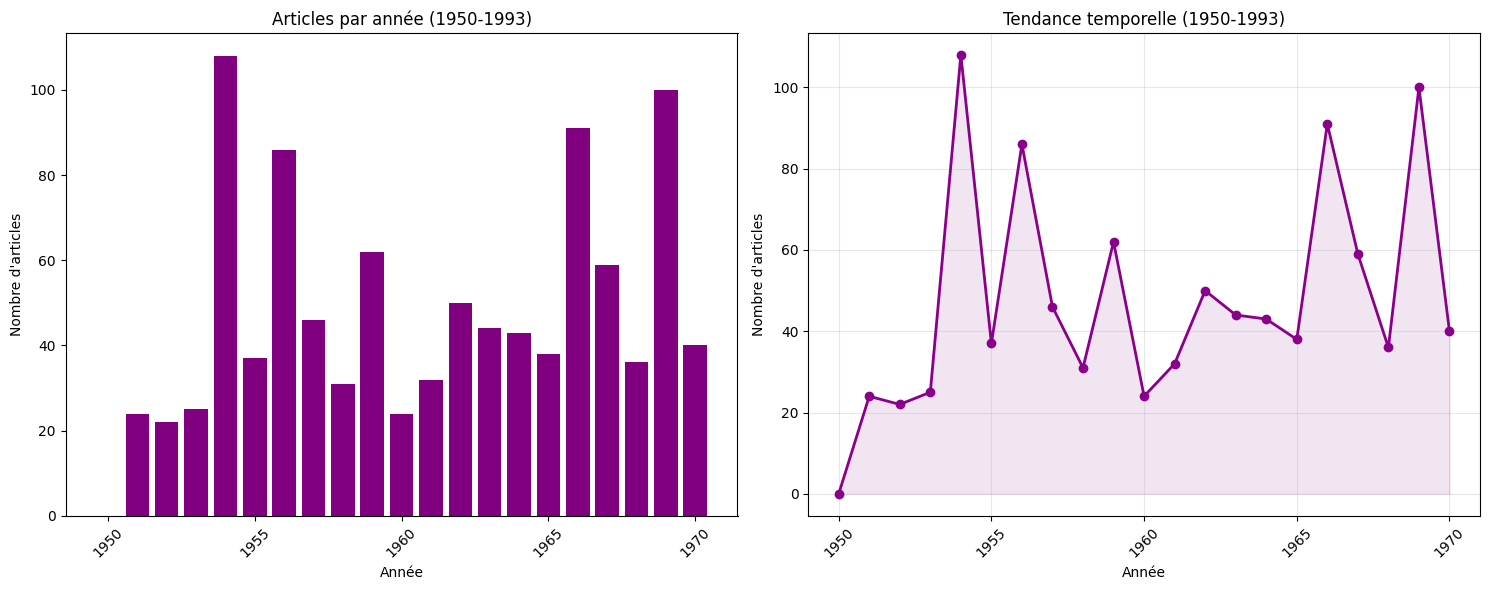


 Années sans articles : [1950]
Vérifiez :
1. La requête CAMille couvre bien 1950-1971
2. Les fichiers sont bien nommés (format KB_XXX_YYYY-MM.txt)
3. Le corpus initial contient bien ces périodes


In [15]:
# --- Analyse temporelle complète ---
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# Initialisation
count_decade = defaultdict(int)
count_year = defaultdict(int)
covered_years = set()

# Extraction des données temporelles
for fname in clean_corpus:
    try:
        year = fname.split("_")[2].split("-")[0]  # Format "KB_123_1985-03.txt"
        decade = f"{year[:3]}0s"
        count_decade[decade] += 1
        count_year[year] += 1
        covered_years.add(year)
    except (IndexError, AttributeError):
        print(f"Format invalide pour {fname}")

# --- Affichage des décennies (y compris vides) ---
all_decades = ["1950s", "1960s", "1970s"]
print("\nNombre d'articles par décennie (1950-1971) :")
for decade in all_decades:
    print(f"{decade}: {count_decade.get(decade, 0)}")

# --- Graphique par année (avec toutes les années 1950-1971) ---
all_years = range(1950, 1971)
yearly_counts = [count_year.get(str(y), 0) for y in all_years]

plt.figure(figsize=(15, 6))

# Graphique en barres
plt.subplot(1, 2, 1)
plt.bar(all_years, yearly_counts, color='purple')
plt.xlabel("Année")
plt.ylabel("Nombre d'articles")
plt.title("Articles par année (1950-1993)")
plt.xticks(range(1950, 1971, 5), rotation=45)

# Graphique en courbe (meilleur pour les tendances)
plt.subplot(1, 2, 2)
plt.plot(all_years, yearly_counts, marker='o', color='darkmagenta', linewidth=2)
plt.fill_between(all_years, yearly_counts, color='purple', alpha=0.1)
plt.xlabel("Année")
plt.ylabel("Nombre d'articles")
plt.title("Tendance temporelle (1950-1993)")
plt.xticks(range(1950, 1971, 5), rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Vérification des années manquantes ---
missing_years = [y for y in all_years if str(y) not in count_year]
if missing_years:
    print(f"\n Années sans articles : {missing_years}")
    print("Vérifiez :")
    print("1. La requête CAMille couvre bien 1950-1971")
    print("2. Les fichiers sont bien nommés (format KB_XXX_YYYY-MM.txt)")
    print("3. Le corpus initial contient bien ces périodes")
